# Prediction As Classification
Continuing the 2800-HK price prediction from classification perspective

## Step 1: Import Modules and load raw data

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import keras

Using TensorFlow backend.


In [2]:
#Import sklearn
from sklearn.preprocessing import scale

In [3]:
#Import Keras module
from keras import optimizers
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
#Load stored variables upon start
%store -r

In [5]:
#pretty plots
%matplotlib inline

In [6]:
#Import price data
#Load the historical prices of 2800-HK, with lags 1 to lag 20
price_hist_data = pd.read_csv('price_only.csv', skiprows=1, parse_dates=['Date']).set_index(['Date'])
price_hist_data.head()

,P,P_L1,P_L2,P_L3,P_L4,P_L5,P_L6,P_L7,P_L8,P_L9,...,P_L11,P_L12,P_L13,P_L14,P_L15,P_L16,P_L17,P_L18,P_L19,P_L20
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-31,24.35,23.80,23.35,23.70,23.90,23.30,23.35,22.70,22.05,21.85,...,20.95,21.70,22.35,22.30,22.05,22.70,22.85,22.15,22.25,22.85
2007-09-03,24.30,24.35,23.80,23.35,23.70,23.90,23.30,23.35,22.70,22.05,...,20.80,20.95,21.70,22.35,22.30,22.05,22.70,22.85,22.15,22.25
2007-09-04,24.30,24.30,24.35,23.80,23.35,23.70,23.90,23.30,23.35,22.70,...,21.85,20.80,20.95,21.70,22.35,22.30,22.05,22.70,22.85,22.15
2007-09-05,24.35,24.30,24.30,24.35,23.80,23.35,23.70,23.90,23.30,23.35,...,22.05,21.85,20.80,20.95,21.70,22.35,22.30,22.05,22.70,22.85
2007-09-06,24.50,24.35,24.30,24.30,24.35,23.80,23.35,23.70,23.90,23.30,...,22.70,22.05,21.85,20.80,20.95,21.70,22.35,22.30,22.05,22.70


In [7]:
#Import Fundamentals Data
fund_data = pd.read_csv('new_index_data.csv', skiprows=1, parse_dates=['Date']).set_index(['Date'])
fund_data.head() 

,Close,High,Low,Ask,Bid,20D Vol,MA5,MA15,MA12,MA20,...,DY_LTM,DY_NTM,ADV_VOL,PAYOUT,ANALYST_SENTIMENT,EPS_GRW_FY1,EPS_GRW_FY2,PE_NTM,PE_LTM,C2D_LTM
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-31,24.35,24.35,24.35,24.35,24.35,2.367823,23.82,22.841667,22.696667,22.6225,...,2.782797,2.880128,99.419898,48.051962,1.909071,30.724490,2.717280,16.695058,16.975805,58.050474
2007-09-03,24.30,24.30,24.30,24.30,24.30,2.266743,23.90,23.120832,22.830000,22.7250,...,2.784563,2.892308,11.570023,48.305678,1.835359,31.005439,1.876752,16.709085,16.925571,58.154835
2007-09-04,24.30,24.30,24.30,24.30,24.30,2.259649,24.02,23.412500,22.960000,22.8325,...,2.784339,2.894377,69.555725,48.307102,1.725886,31.040968,1.891823,16.697662,16.919413,58.177640
2007-09-05,24.35,24.35,24.35,24.35,24.35,2.172140,24.22,23.620832,23.136667,22.9075,...,2.767348,2.867314,24.265623,48.267351,1.741908,30.716929,1.878484,16.841225,17.017692,58.195446
2007-09-06,24.50,24.50,24.50,24.50,24.50,2.160638,24.36,23.825000,23.373333,22.9975,...,2.775339,2.878880,88.845002,48.288397,1.696151,31.336520,1.861943,16.780660,16.975485,58.224743


In [8]:
#Import Global index data
idx_data = pd.read_csv('indices.csv', skiprows=1, parse_dates=['Date']).set_index(['Date'])
idx_data.head()

,Hang Seng Index,SSE Composite Index,ASX All Ordinaries,India S&P BSE SENSEX,TOPIX,KOSPI Composite Index,Taiwan TAIEX,FTSE Bursa Malaysia KLCI,FTSE Straits Times Index,Philippines PSE PSEi,...,Turkey BIST 100,S&P 500,DJ Industrial Average,Colombia IGBC,Canada S&P/TSX Composite,Brazil Bovespa Index,Mexico IPC,Israel TA-125,Saudi Arabia All Share (TASI),FTSE JSE All Share
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-31,23984.14,5218.825,6248.3,15318.60,1608.25,1873.24,8982.16,1273.93,3328.43,3365.29,...,50198.60,1473.99,13357.74,10728.74,13660.48,54637.24,30347.86,1034.67,8226.97,28660.35
2007-09-03,23904.09,5321.055,6272.5,15422.05,1605.44,1881.81,8979.96,1284.14,3321.36,3369.14,...,49936.94,1473.99,13357.74,10750.79,13660.48,54832.51,30797.60,1047.33,8017.54,28887.48
2007-09-04,23886.07,5294.045,6297.1,15465.40,1596.74,1874.74,8922.98,1283.75,3308.81,3312.30,...,50032.59,1489.42,13448.86,10880.85,13755.23,55250.47,30932.71,1054.69,7878.70,29051.96
2007-09-05,24069.17,5310.716,6274.3,15446.15,1569.47,1865.59,8913.85,1297.93,3375.02,3342.35,...,49421.38,1472.29,13305.47,10819.91,13683.28,54407.83,30809.55,1048.70,7853.66,28696.67
2007-09-06,24050.40,5393.660,6265.3,15616.31,1568.52,1888.81,9017.08,1298.85,3399.49,3326.53,...,49601.39,1478.55,13363.35,10844.40,13795.69,54569.00,30816.95,1033.23,7853.66,28850.19


## Step 2: Pre-process Raw Data
1. Generate labels
2. Apply lags to global index data
3. Normalize features

In [9]:
#Generate Labels from Price History Data
#Generate UP/DOWN labels from log change
cutoff_perc = 0.0005 #0.05% return as cuttoff to define UP label
lag = 1 #forward returns

labels = np.zeros([price_hist_data.shape[0]])

#Caluclate log-returns
ret = np.log(price_hist_data['P'].shift(-lag)/price_hist_data['P'])
labels = [1 if r > cutoff_perc else 0 for r in ret]

In [10]:
#Applying lags to index data
#Seperate the indices into 2 classes - lag or no_lag
no_lag = [0, 1, 2, 4, 5, 6, 9, 10]
lag = [i for i in range(0,idx_data.shape[1]) if i not in no_lag]

#Processing the dataset by applying appropriate lags
lagged_data = idx_data.iloc[:,lag].shift(1)
idx_data = pd.concat([idx_data.iloc[:,no_lag], lagged_data], axis=1)


In [11]:
#Remove first row
idx_data = idx_data.iloc[1:, :]
price_hist_data = price_hist_data.iloc[1:, :]
fund_data = fund_data.iloc[1:, :]
labels=labels[1:]

In [12]:
#Check Dimensions to make sure everythings right before continuing..
print("Shape of idx_data: ", idx_data.shape)
print("Shape of price_hist_data: ", price_hist_data.shape)
print("Shape of fund_data: ", fund_data.shape)
print("Shape of labels: ", len(labels))

Shape of idx_data:  (2483, 42)
Shape of price_hist_data:  (2483, 21)
Shape of fund_data:  (2483, 30)
Shape of labels:  2483


In [13]:
#Training data
X = np.array(pd.concat([price_hist_data, idx_data, fund_data], axis=1))
y = to_categorical(labels, num_classes=2)

In [14]:
#Checking whether there are NAs
[np.sum(np.isnan(X), axis=0) > 0] == True

False

## Step 3: Split training, validation and test set

In this stage we have a look-ahead bias free set of data (X) and the labels y. Next, we will need to:
- Normalize the input data. To avoid look ahead bias, we will z-score the features, using ONLY the training set.
- Next, generate input data into LSTM network. We will need an overlapping sequence at 1-day window as input samples. Specifically suppose the *timestep* is 240, we will have a list of array consists of *number of rows of X* - 240 entries, each element has dimentions (240, num_of_features)


In [15]:
#Function to split raw data into training, validation and test set, returns a numpy array.
def split_data(input_data=[], train_size=0.8, val_size=0.2, test_size=0):
    
    #------------------------------------------------
    #PARAM: input_data: numpy nd array
    #PARAM: training_size: size of training set in decimal
    #PARAM: val_size: size of validation set in decimal
    #PARAM: test_size: size of test set in decimal
    #OUTPUT: tuple (train_set, validation_set, test_set)
    #------------------------------------------------
    
    #First check whether traing_size + val_size + test_size = 1 and each of the entries are positive
    assert(train_size + val_size + test_size==1), "Sum of training, validation and test size needs to be 1!"
    assert(train_size * val_size * test_size > 0), "Sizes have to be positive!"
    
    #Check input_data type is numpy array, after casting
    if type(input_data) != 'numpy.ndarray':
        input_data = np.array(input_data) 
    
    assert(isinstance(input_data, np.ndarray)), "Input has to be a numpy array!"
    
    
    #Calculate cut-off points
    train_cut_index = int(train_size * input_data.shape[0])
    val_cut_index = train_cut_index + int(val_size * input_data.shape[0])
    
    #Split the data
    if len(input_data.shape) == 1:
        train, val, test = input_data[:train_cut_index], input_data[train_cut_index:val_cut_index], input_data[val_cut_index:]
    else:
        train, val, test = input_data[:train_cut_index,:], input_data[train_cut_index:val_cut_index, :], input_data[val_cut_index:, :]
    
    return train, val, test

In [16]:
#------------
#TEST OUTPUT
#------------
#Split data
X_train, X_val, X_test = split_data(X, train_size=0.6, val_size=0.2, test_size=0.2)
y_train, y_val, y_test = split_data(y, train_size=0.6, val_size=0.2, test_size=0.2)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1489, 93)
(496, 93)
(498, 93)
(1489, 2)
(496, 2)
(498, 2)


In [17]:
#Function to re-structure the data to get batches. Re-shape the data to have overlapping training set for time-series learning.
def get_inputs(input_data, labels, batch_size, timesteps):
    
    #First get the total number of samples generated
    n_seq = input_data.shape[0] - timesteps + 1
    
    #features, classes
    n_dim = input_data.shape[1]
    n_class = labels.shape[1]
    
    #Calculate the number of batches possible
    n_samples = n_seq * timesteps
    n_batches = n_samples // (batch_size * timesteps)

    output = []
    targets = []
        
    for jj in range(0, n_batches):
    #Generate the sequences
        
        #if jj == n_batches:
            
            #output.append([input_data[jj*batch_size:, :]])
            #targets.append([labels[jj*batch_size:, :]])            
            #yield np.vstack(output), np.vstack(targets  )
            
        #else:            
        for ii in range(jj * batch_size, (jj + 1) * batch_size):                    
            #Getting the overlapping samples
            output.append([scale(input_data[ii:ii + timesteps, :])])
            targets.append([labels[ii:ii+timesteps, :]])

    return np.vstack(output), np.vstack(targets)


In [18]:
#------------
#TEST OUTPUT
#------------
#get inputs
t = np.reshape(np.arange(1,51), (10,5))
s = np.reshape(np.arange(1,21), (10,2))

#for (x, y) in get_inputs(t,s, 3, 4):
#    print('training size: ', x.shape)
#    print('training: \n', x)
#    print('label size: ', y.shape)
#    print('labels: \n', y)

test_train, test_label = get_inputs(t,s,3,4)
    

#print(test_train[0:1])
#print(test_label[0:1])
#print(t)
print(test_train.shape)
print(test_label.shape)
#print(test_train)
#test_train.reshape((-1, 4, 5))

(6, 4, 5)
(6, 4, 2)


/home/carnd/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/carnd/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/carnd/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/carnd/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/carnd/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversio

## Step 4: Train Model

In [19]:
#Define Parameters
learning_rate = 0.0005
epochs= 100
loss = 'binary_crossentropy'
batch_size = 256
timesteps = 22
n_dim = X.shape[1]
n_classes = 2


In [20]:
#Optimizer - using Adam Optimizer
optimizer = optimizers.Adam(lr=learning_rate)

In [21]:
#Generate Inputs
X_train_1, y_train_1 = get_inputs(X_train, y_train, batch_size, timesteps)
X_val_1, y_val_1 = get_inputs(X_val, y_val, batch_size, timesteps)
X_test_1, y_test_1 = get_inputs(X_test, y_test, batch_size, timesteps)

In [22]:
#Define LSTM Network object
def build_network(n_hidden_layer, dropout, input_shape, batch_size, return_sequences=True, stateful=True):
    
    #Define network architect
    model = Sequential()
    model.add(LSTM(n_hidden_layer[0], input_shape=input_shape, batch_size=batch_size, return_sequences=return_sequences, stateful=stateful))
    model.add(Dropout(dropout[0]))
    model.add(LSTM(n_hidden_layer[1], return_sequences=return_sequences, stateful=stateful))
    model.add(Dropout(dropout[0]))
    model.add(Dense(n_hidden_layer[2], activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    
    return model

In [23]:
#lstm1 = build_network([5,5,10], [0.1,0.1], input_shape=(timesteps, n_dim), batch_size=batch_size)

In [24]:
#Compile
#lstm1.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [25]:
#fitted = lstm1.fit(X_train_1, y_train_1, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_val_1, y_val_1), shuffle=True)

## Step 5: Evaluate


In [26]:
### Plot Training vs Validation Curve
def plot_loss(fitted):
    plt.figure()
    plt.plot(fitted.history['loss'])
    plt.plot(fitted.history['val_loss'])
    plt.title('Training Loss & Validation Loss')
    plt.ylabel('Binary Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.show()

In [27]:
### Plot Training vs Validation Accuracy
def plot_accuracy(fitted):
    plt.figure()
    plt.plot(fitted.history['acc'])
    plt.plot(fitted.history['val_acc'])
    plt.title('Training Accuracy & Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.show()

## Step 6: Parameter Tuning


Grid Search the following parameters:
- Learning Rate & decay rate
- Number of Hidden Layers
- Dropout Rate
- Timesteps

In [28]:
%store -r

In [29]:
%store

Stored variables and their in-db values:
best_drop_out             -> (0.25, 0.25)
best_lr                   -> 4.9999999999999996e-05
best_n_hidden             -> (45, 25, 50)
best_timestep             -> 17
do_loss                   -> [[0.69356894493103027], [0.68898439407348633], [0.
hd_loss                   -> [[0.69319874048233032], [0.69006013870239258], [0.
lr_loss                   -> [[0.68081382910410559], [0.67485751708348596], [0.
t_loss                    -> [[0.68911886215209961], [0.69271934032440186], [0.


### Learning Rate

In [ ]:
#Grid Search for learning rate, at fixed 100 epochs.
#lr = np.linspace(1e-5, 1e-3, 1)
lr = np.linspace(1e-5, 1e-3, 100)

In [ ]:
#Initiate empty list to store best validation loss for a particular learning rate
lr_loss = []
steps = 1

#Build network
lr_network = build_network([5,5,10], [0,0], input_shape=(timesteps, n_dim), batch_size=batch_size)

#Loop through the learning rate and train network
for learning_rate in lr:
    
    #Optimizer
    optimizer = optimizers.Adam(lr=learning_rate)
    
    #Compile
    lr_network.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    #Train
    fitted_lr = lr_network.fit(X_train_1, y_train_1, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_val_1, y_val_1), shuffle=True)
    
    #Display
    print('Steps: %d, learning rate: %.6f, Best Validation Loss: %.4f' %(steps, learning_rate, np.min(fitted_lr.history['val_loss'])))
    
    #Save
    lr_loss.append([np.min(fitted_lr.history['val_loss'])])
    
    #Update
    steps += 1

In [ ]:
#Best Learning Rate
best_lr = lr[np.argmin(lr_loss)]
best_lr_loss = np.min(lr_loss)
print('Best Learning Rate: %.5f' % best_lr)
print('Validation Loss: %.5f' % np.argmin(lr_loss))
%store best_lr
%store lr_loss

In [ ]:
#Plot Learning Rate vs Validation Loss
plt.plot(lr*1e4, lr_loss)
plt.title('Learning Rate vs Validation Loss')
plt.xlabel('Learning Rate (x 10^-4)')
plt.ylabel('Validation Loss')
plt.show()

## Number of Hidden Layers

In [33]:
#Generate number of layers
n_hidden_layers = np.arange(5,51,10)
n_dense = np.arange(10,51,10)
n_layers = list(itertools.product(n_hidden_layers, n_hidden_layers, n_dense))

In [35]:
#Initiate empty list to store best validation loss for a particular learning rate
hd_loss = []
steps = 1

#Build network


#Loop through the learning rate and train network
for (hd1, hd2, d) in n_layers:
    
    hd_network = build_network([hd1, hd2, d], [0,0], input_shape=(timesteps, n_dim), batch_size=batch_size)
    
    #Optimizer
    optimizer = optimizers.Adam(lr=best_lr)
    
    #Compile
    hd_network.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    #Train
    fitted_hidden = hd_network.fit(X_train_1, y_train_1, batch_size=batch_size, epochs=10, verbose=0, validation_data=(X_val_1, y_val_1), shuffle=True)
    
    #Display
    print('Steps: %d,' % steps, 'Number of layers: (%d, %d, %d), ' % (hd1, hd2, d), 'Best Validation Loss: %.4f' %  np.min(fitted_hidden.history['val_loss']))
    
    #Save
    hd_loss.append([np.min(fitted_hidden.history['val_loss'])])
    
    #Update
    steps += 1

Steps: 1, Number of layers: (5, 5, 10),  Best Validation Loss: 0.6932
Steps: 2, Number of layers: (5, 5, 20),  Best Validation Loss: 0.6901
Steps: 3, Number of layers: (5, 5, 30),  Best Validation Loss: 0.6933
Steps: 4, Number of layers: (5, 5, 40),  Best Validation Loss: 0.6939
Steps: 5, Number of layers: (5, 5, 50),  Best Validation Loss: 0.6943
Steps: 6, Number of layers: (5, 15, 10),  Best Validation Loss: 0.6943
Steps: 7, Number of layers: (5, 15, 20),  Best Validation Loss: 0.6942
Steps: 8, Number of layers: (5, 15, 30),  Best Validation Loss: 0.6915
Steps: 9, Number of layers: (5, 15, 40),  Best Validation Loss: 0.6943
Steps: 10, Number of layers: (5, 15, 50),  Best Validation Loss: 0.6924
Steps: 11, Number of layers: (5, 25, 10),  Best Validation Loss: 0.6888
Steps: 12, Number of layers: (5, 25, 20),  Best Validation Loss: 0.6918
Steps: 13, Number of layers: (5, 25, 30),  Best Validation Loss: 0.6943
Steps: 14, Number of layers: (5, 25, 40),  Best Validation Loss: 0.6900
Steps:

Steps: 114, Number of layers: (45, 25, 40),  Best Validation Loss: 0.6872
Steps: 115, Number of layers: (45, 25, 50),  Best Validation Loss: 0.6734
Steps: 116, Number of layers: (45, 35, 10),  Best Validation Loss: 0.6904
Steps: 117, Number of layers: (45, 35, 20),  Best Validation Loss: 0.6881
Steps: 118, Number of layers: (45, 35, 30),  Best Validation Loss: 0.6889
Steps: 119, Number of layers: (45, 35, 40),  Best Validation Loss: 0.6826
Steps: 120, Number of layers: (45, 35, 50),  Best Validation Loss: 0.6882
Steps: 121, Number of layers: (45, 45, 10),  Best Validation Loss: 0.6834
Steps: 122, Number of layers: (45, 45, 20),  Best Validation Loss: 0.6854
Steps: 123, Number of layers: (45, 45, 30),  Best Validation Loss: 0.6918
Steps: 124, Number of layers: (45, 45, 40),  Best Validation Loss: 0.6884
Steps: 125, Number of layers: (45, 45, 50),  Best Validation Loss: 0.6818


In [36]:
#Best number of hidden layer
best_n_hidden = n_layers[np.argmin(hd_loss)]
best_hidden_loss = np.min(hd_loss)
print('Best Number of Hidden Layer: ', best_n_hidden, " Validation Loss: %.4f " % best_hidden_loss)
%store best_n_hidden
%store hd_loss

Best Number of Hidden Layer:  (45, 25, 50)  Validation Loss: 0.6734 
Stored 'best_n_hidden' (tuple)
Stored 'hd_loss' (list)


## Dropout rate

In [30]:
#Setting Drop out rate
drop_out = list(itertools.combinations_with_replacement(np.linspace(0.1,0.9, num=17),2))

In [31]:
#Initiate empty list to store best validation loss for a particular learning rate
do_loss = []
steps = 1

#Build network


#Loop through the learning rate and train network
for d in drop_out:
    
    do_network = build_network(best_n_hidden, d, input_shape=(timesteps, n_dim), batch_size=batch_size)
    
    #Optimizer
    optimizer = optimizers.Adam(lr=best_lr)
    
    #Compile
    do_network.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    #Train
    fitted_dropout = do_network.fit(X_train_1, y_train_1, batch_size=batch_size, epochs=10, verbose=0, validation_data=(X_val_1, y_val_1), shuffle=True)
    
    #Display
    print('Steps: %d,' %steps, 'Dropout: (%.4f, %.4f) ' % d, 'Best Validation Loss: %.4f' % np.min(fitted_dropout.history['val_loss']))
    
    #Save
    do_loss.append([np.min(fitted_dropout.history['val_loss'])])
    
    #Update
    steps += 1

Steps: 1, Dropout: (0.1000, 0.1000)  Best Validation Loss: 0.6936
Steps: 2, Dropout: (0.1000, 0.1500)  Best Validation Loss: 0.6890
Steps: 3, Dropout: (0.1000, 0.2000)  Best Validation Loss: 0.6850
Steps: 4, Dropout: (0.1000, 0.2500)  Best Validation Loss: 0.6873
Steps: 5, Dropout: (0.1000, 0.3000)  Best Validation Loss: 0.6843
Steps: 6, Dropout: (0.1000, 0.3500)  Best Validation Loss: 0.6937
Steps: 7, Dropout: (0.1000, 0.4000)  Best Validation Loss: 0.6869
Steps: 8, Dropout: (0.1000, 0.4500)  Best Validation Loss: 0.6902
Steps: 9, Dropout: (0.1000, 0.5000)  Best Validation Loss: 0.6825
Steps: 10, Dropout: (0.1000, 0.5500)  Best Validation Loss: 0.6891
Steps: 11, Dropout: (0.1000, 0.6000)  Best Validation Loss: 0.6898
Steps: 12, Dropout: (0.1000, 0.6500)  Best Validation Loss: 0.6861
Steps: 13, Dropout: (0.1000, 0.7000)  Best Validation Loss: 0.6878
Steps: 14, Dropout: (0.1000, 0.7500)  Best Validation Loss: 0.6870
Steps: 15, Dropout: (0.1000, 0.8000)  Best Validation Loss: 0.6887
Step

Steps: 124, Dropout: (0.5500, 0.8500)  Best Validation Loss: 0.6867
Steps: 125, Dropout: (0.5500, 0.9000)  Best Validation Loss: 0.6887
Steps: 126, Dropout: (0.6000, 0.6000)  Best Validation Loss: 0.6868
Steps: 127, Dropout: (0.6000, 0.6500)  Best Validation Loss: 0.6859
Steps: 128, Dropout: (0.6000, 0.7000)  Best Validation Loss: 0.6910
Steps: 129, Dropout: (0.6000, 0.7500)  Best Validation Loss: 0.6909
Steps: 130, Dropout: (0.6000, 0.8000)  Best Validation Loss: 0.6907
Steps: 131, Dropout: (0.6000, 0.8500)  Best Validation Loss: 0.6857
Steps: 132, Dropout: (0.6000, 0.9000)  Best Validation Loss: 0.6838
Steps: 133, Dropout: (0.6500, 0.6500)  Best Validation Loss: 0.6889
Steps: 134, Dropout: (0.6500, 0.7000)  Best Validation Loss: 0.6892
Steps: 135, Dropout: (0.6500, 0.7500)  Best Validation Loss: 0.6791
Steps: 136, Dropout: (0.6500, 0.8000)  Best Validation Loss: 0.6894
Steps: 137, Dropout: (0.6500, 0.8500)  Best Validation Loss: 0.6936
Steps: 138, Dropout: (0.6500, 0.9000)  Best Vali

In [32]:
best_drop_out = drop_out[np.argmin(do_loss)]
best_do_loss = np.min(do_loss)
print('Best Drop out probability: (%.2f, %.2f), ' % best_drop_out, 'Validation Loss: %.4f' % best_do_loss)

%store best_drop_out
%store do_loss

Best Drop out probability: (0.25, 0.25),  Validation Loss: 0.6754
Stored 'best_drop_out' (tuple)
Stored 'do_loss' (list)


## Timesteps

In [38]:
#Test timesteps from 1 step to 220 days lag
time = np.arange(10,200)

In [39]:
#Initiate empty list to store best validation loss for a particular timestep
t_loss = []
steps = 1


#Loop through the learning rate and train network
for t in time:
    
    #Generate inputs on timesteps
    X_train_2, y_train_2 = get_inputs(X_train, y_train, batch_size, t)
    X_val_2, y_val_2 = get_inputs(X_val, y_val, batch_size, t)
    
    #Build network
    t_network = build_network(best_n_hidden, best_drop_out, input_shape=(t, n_dim), batch_size=batch_size)
    
    #Optimizer
    optimizer = optimizers.Adam(lr=best_lr)
    
    #Compile
    t_network.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    #Train
    fitted_timesteps = t_network.fit(X_train_2, y_train_2, batch_size=batch_size, epochs=5, verbose=0, validation_data=(X_val_2, y_val_2), shuffle=True)
    
    #Display
    print('Steps: %d,' % steps, 'Timesteps: %d' % t, 'Best Validation Loss: %.4f' % np.min(fitted_timesteps.history['val_loss']))
    
    #Save
    t_loss.append([np.min(fitted_timesteps.history['val_loss'])])
    
    #Update
    steps += 1

Steps: 1, Timesteps: 10 Best Validation Loss: 0.6891
Steps: 2, Timesteps: 11 Best Validation Loss: 0.6927
Steps: 3, Timesteps: 12 Best Validation Loss: 0.6954
Steps: 4, Timesteps: 13 Best Validation Loss: 0.6905
Steps: 5, Timesteps: 14 Best Validation Loss: 0.6896
Steps: 6, Timesteps: 15 Best Validation Loss: 0.6932
Steps: 7, Timesteps: 16 Best Validation Loss: 0.6949
Steps: 8, Timesteps: 17 Best Validation Loss: 0.6839
Steps: 9, Timesteps: 18 Best Validation Loss: 0.6920
Steps: 10, Timesteps: 19 Best Validation Loss: 0.6956
Steps: 11, Timesteps: 20 Best Validation Loss: 0.6898
Steps: 12, Timesteps: 21 Best Validation Loss: 0.6862
Steps: 13, Timesteps: 22 Best Validation Loss: 0.6898
Steps: 14, Timesteps: 23 Best Validation Loss: 0.6999
Steps: 15, Timesteps: 24 Best Validation Loss: 0.6943
Steps: 16, Timesteps: 25 Best Validation Loss: 0.6894
Steps: 17, Timesteps: 26 Best Validation Loss: 0.6863
Steps: 18, Timesteps: 27 Best Validation Loss: 0.6895
Steps: 19, Timesteps: 28 Best Validat

Steps: 151, Timesteps: 160 Best Validation Loss: 0.6904
Steps: 152, Timesteps: 161 Best Validation Loss: 0.6983
Steps: 153, Timesteps: 162 Best Validation Loss: 0.6934
Steps: 154, Timesteps: 163 Best Validation Loss: 0.6961
Steps: 155, Timesteps: 164 Best Validation Loss: 0.6912
Steps: 156, Timesteps: 165 Best Validation Loss: 0.6924
Steps: 157, Timesteps: 166 Best Validation Loss: 0.6934
Steps: 158, Timesteps: 167 Best Validation Loss: 0.6947
Steps: 159, Timesteps: 168 Best Validation Loss: 0.6928
Steps: 160, Timesteps: 169 Best Validation Loss: 0.6927
Steps: 161, Timesteps: 170 Best Validation Loss: 0.6908
Steps: 162, Timesteps: 171 Best Validation Loss: 0.6894
Steps: 163, Timesteps: 172 Best Validation Loss: 0.6906
Steps: 164, Timesteps: 173 Best Validation Loss: 0.6919
Steps: 165, Timesteps: 174 Best Validation Loss: 0.6926
Steps: 166, Timesteps: 175 Best Validation Loss: 0.6910
Steps: 167, Timesteps: 176 Best Validation Loss: 0.6937
Steps: 168, Timesteps: 177 Best Validation Loss:

In [40]:
best_timestep = time[np.argmin(t_loss)]
best_t_loss = np.min(t_loss)
print('Best Drop out probability: (%.2f, %.2f), ' % best_drop_out, 'Validation Loss: %.4f' % best_t_loss)

%store best_timestep
%store t_loss

Best Drop out probability: (0.25, 0.25),  Validation Loss: 0.6839
Stored 'best_timestep' (int64)
Stored 't_loss' (list)


In [41]:
print('Summary')
print('-------------')
print('Learning Rate: %.5f' % best_lr)
print('Number of layers: ', best_n_hidden)
print('Dropout Probability: (%.2f, %.2f)' % best_drop_out)
print('Timesteps: ', best_timestep)

Summary
-------------
Learning Rate: 0.00005
Number of layers:  (45, 25, 50)
Dropout Probability: (0.25, 0.25)
Timesteps:  17


## Step 8: Refit using best parameters


In [45]:
X_train_best, y_train_best = get_inputs(X_train, y_train, batch_size, best_timestep)
X_val_best, y_val_best = get_inputs(X_val, y_val, batch_size, best_timestep)

In [46]:
best_network = build_network(best_n_hidden, best_drop_out, input_shape=(best_timestep, n_dim), batch_size=batch_size)
optimizer = optimizers.Adam(lr=best_lr)
best_network.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
best_fit = best_network.fit(X_train_best, y_train_best, batch_size=batch_size, epochs=500, verbose=1, validation_data=(X_val_best, y_val_best), shuffle=True)

Train on 1280 samples, validate on 256 samples
Epoch 1/500
1280/1280 [==============================] - 15s - loss: 0.6953 - acc: 0.4993 - val_loss: 0.6951 - val_acc: 0.4954
Epoch 2/500
1280/1280 [==============================] - 0s - loss: 0.6947 - acc: 0.5033 - val_loss: 0.6945 - val_acc: 0.4964
Epoch 3/500
1280/1280 [==============================] - 0s - loss: 0.6939 - acc: 0.5082 - val_loss: 0.6934 - val_acc: 0.4998
Epoch 4/500
1280/1280 [==============================] - 0s - loss: 0.6929 - acc: 0.5147 - val_loss: 0.6927 - val_acc: 0.5082
Epoch 5/500
1280/1280 [==============================] - 0s - loss: 0.6925 - acc: 0.5128 - val_loss: 0.6922 - val_acc: 0.5115
Epoch 6/500
1280/1280 [==============================] - 0s - loss: 0.6911 - acc: 0.5269 - val_loss: 0.6913 - val_acc: 0.5190
Epoch 7/500
1280/1280 [==============================] - 0s - loss: 0.6902 - acc: 0.5337 - val_loss: 0.6910 - val_acc: 0.5226
Epoch 8/500
1280/1280 [==============================] - 0s - loss: 0.

1280/1280 [==============================] - 0s - loss: 0.6181 - acc: 0.6625 - val_loss: 0.6467 - val_acc: 0.6280
Epoch 130/500
1280/1280 [==============================] - 0s - loss: 0.6190 - acc: 0.6612 - val_loss: 0.6440 - val_acc: 0.6276
Epoch 131/500
1280/1280 [==============================] - 0s - loss: 0.6178 - acc: 0.6622 - val_loss: 0.6450 - val_acc: 0.6249
Epoch 132/500
1280/1280 [==============================] - 0s - loss: 0.6168 - acc: 0.6662 - val_loss: 0.6423 - val_acc: 0.6295
Epoch 133/500
1280/1280 [==============================] - 0s - loss: 0.6171 - acc: 0.6617 - val_loss: 0.6405 - val_acc: 0.6315
Epoch 134/500
1280/1280 [==============================] - 0s - loss: 0.6165 - acc: 0.6640 - val_loss: 0.6427 - val_acc: 0.6302
Epoch 135/500
1280/1280 [==============================] - 0s - loss: 0.6160 - acc: 0.6624 - val_loss: 0.6404 - val_acc: 0.6364
Epoch 136/500
1280/1280 [==============================] - 0s - loss: 0.6153 - acc: 0.6635 - val_loss: 0.6448 - val_ac

1280/1280 [==============================] - 0s - loss: 0.5668 - acc: 0.7101 - val_loss: 0.6550 - val_acc: 0.6343
Epoch 258/500
1280/1280 [==============================] - 0s - loss: 0.5670 - acc: 0.7121 - val_loss: 0.6616 - val_acc: 0.6350
Epoch 259/500
1280/1280 [==============================] - 0s - loss: 0.5650 - acc: 0.7116 - val_loss: 0.6548 - val_acc: 0.6368
Epoch 260/500
1280/1280 [==============================] - 0s - loss: 0.5658 - acc: 0.7095 - val_loss: 0.6564 - val_acc: 0.6390
Epoch 261/500
1280/1280 [==============================] - 0s - loss: 0.5612 - acc: 0.7135 - val_loss: 0.6533 - val_acc: 0.6435
Epoch 262/500
1280/1280 [==============================] - 0s - loss: 0.5619 - acc: 0.7133 - val_loss: 0.6561 - val_acc: 0.6349
Epoch 263/500
1280/1280 [==============================] - 0s - loss: 0.5626 - acc: 0.7115 - val_loss: 0.6580 - val_acc: 0.6351
Epoch 264/500
1280/1280 [==============================] - 0s - loss: 0.5623 - acc: 0.7152 - val_loss: 0.6571 - val_ac

1280/1280 [==============================] - 0s - loss: 0.5156 - acc: 0.7492 - val_loss: 0.6866 - val_acc: 0.6321
Epoch 386/500
1280/1280 [==============================] - 0s - loss: 0.5186 - acc: 0.7489 - val_loss: 0.6876 - val_acc: 0.6320
Epoch 387/500
1280/1280 [==============================] - 0s - loss: 0.5156 - acc: 0.7527 - val_loss: 0.6901 - val_acc: 0.6296
Epoch 388/500
1280/1280 [==============================] - 0s - loss: 0.5211 - acc: 0.7503 - val_loss: 0.6950 - val_acc: 0.6399
Epoch 389/500
1280/1280 [==============================] - 0s - loss: 0.5187 - acc: 0.7509 - val_loss: 0.6885 - val_acc: 0.6349
Epoch 390/500
1280/1280 [==============================] - 0s - loss: 0.5209 - acc: 0.7464 - val_loss: 0.6884 - val_acc: 0.6363
Epoch 391/500
1280/1280 [==============================] - 0s - loss: 0.5212 - acc: 0.7460 - val_loss: 0.6939 - val_acc: 0.6366
Epoch 392/500
1280/1280 [==============================] - 0s - loss: 0.5174 - acc: 0.7511 - val_loss: 0.6951 - val_ac

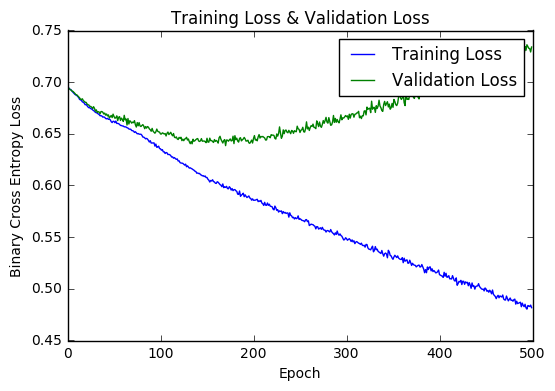

In [47]:
plot_loss(best_fit)

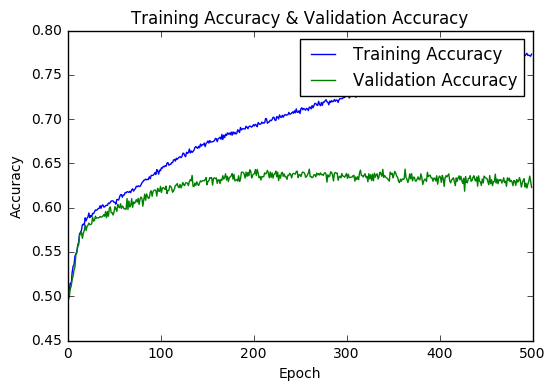

In [48]:
plot_accuracy(best_fit)